# Barton Springs Salamanders & Watershed Quality Report
### Benjamin Goad, Michelle Gelman, Nick Hoang, Daphne Lopez

Import libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,date as dt
import sklearn as sk

### Data Prep
Read in the data set and print out the head

In [23]:
rawData  = pd.DataFrame(pd.read_csv("Barton_Springs_Salamanders_DO_and_Flow.csv"))
rawData.head(1000)

/home/user/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3135: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,WATERSHED,SAMPLE_DATE,SITE_NAME,LON_DD_WGS84,LAT_DD_WGS84,SITE_TYPE,MEDIUM,PARAM_TYPE,PARAMETER,QUALIFIER,...,FILTER,SAMPLE_ID,SAMPLE_SITE_NO,METHOD,QC_FLAG,PROJECT,DATA_REF_NO,SAMPLE_REF_NO,TIME_NULL,QC_TYPE
0,Barton Creek,07/06/1990 12:00:00 AM,Barton Spring,-97.770980,30.263535,Spring,Surface Water,Oxygen,DISSOLVED OXYGEN,NaN,...,Dissolved,NaN,35,UNKNOWN,U,Water Watch Dog,2387519,479314,Y,NaN
1,Barton Creek,07/01/1991 12:00:00 AM,Barton Spring,-97.770980,30.263535,Spring,Surface Water,Oxygen,DISSOLVED OXYGEN,NaN,...,Dissolved,NaN,35,HACH TEST KIT,U,Water Watch Dog,1053022,67681,Y,NaN
2,Barton Creek,08/02/1991 12:00:00 AM,Barton Spring,-97.770980,30.263535,Spring,Surface Water,Oxygen,DISSOLVED OXYGEN,NaN,...,Dissolved,NaN,35,HACH TEST KIT,U,Water Watch Dog,557211,67682,Y,NaN
3,Barton Creek,10/11/1991 12:00:00 AM,Barton Spring,-97.770980,30.263535,Spring,Surface Water,Oxygen,DISSOLVED OXYGEN,NaN,...,Dissolved,NaN,35,HACH TEST KIT,U,Water Watch Dog,1052978,67677,Y,NaN
4,Barton Creek,06/04/1992 11:00:00 AM,Barton Spring,-97.770980,30.263535,Spring,Surface Water,Oxygen,DISSOLVED OXYGEN,NaN,...,Dissolved,NaN,35,UNKNOWN,U,Water Watch Dog,2335102,450308,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Barton Creek,04/12/2001 12:00:00 AM,Eliza Spring,-97.770061,30.264246,Spring,Benthic Cover,Salamanders,AUSTIN BLIND SLMNDR (<1IN.) (JUVENILE),NaN,...,Total,NaN,428,VISUAL ASSESSMENT,U,Barton Springs Salamander,1705157,342910,Y,NaN
996,Barton Creek,04/12/2001 12:00:00 AM,Eliza Spring,-97.770061,30.264246,Spring,Benthic Cover,Salamanders,AUSTIN BLIND SALMNDR (ADULT) > 1 INCH,NaN,...,Total,NaN,428,VISUAL ASSESSMENT,U,Barton Springs Salamander,1705158,342910,Y,NaN
997,Barton Creek,04/12/2001 12:00:00 AM,Eliza Spring,-97.770061,30.264246,Spring,Benthic Cover,Salamanders,SALAMANDER (UNKNOWN LENGTH),NaN,...,Total,NaN,428,VISUAL ASSESSMENT,U,Barton Springs Salamander,1680711,342910,Y,NaN
998,Barton Creek,04/12/2001 12:00:00 AM,Eliza Spring,-97.770061,30.264246,Spring,Benthic Cover,Salamanders,AUSTIN BLIND SALAMANDER (UNKNOWN LENGTH),NaN,...,Total,NaN,428,VISUAL ASSESSMENT,U,Barton Springs Salamander,1705163,342910,Y,NaN


## Feature Engineering Plan
- [ ] aggregate sample IDS by parameter types:
    - [ ] get result and unit for each paramater type
    - [ ] do cleanintg for null values
    - [ ] print out a scatter plot for each paratamer_type(check for outliers before normalizing)
    - [ ] print out statistics on each (std, mean, var -> maybe add each as a new column)
    - [ ] groupBy time_null-> see how many records dont have a date. do a time series plot for result + time for each salamander parameter
## What data might we need?
 - how do we condiser the other paramater types? We could maybe see the days when samples were collected, and add salamander paramater as a new feature. Groupby site name?
 - how do salamander poplations vary at different types?
 - what paramater types have a (+/-) correlation with salamnder populations?
 - do any of the paramater types have an affect on the salamnder sizes? does the season explain it, or is it something about the paramater type at that site?
 - maybe we could get a data set with mineral content or weather data? what about water levels?
- [ ] Don't need qualifier, sample IDs, filter, don't need sample_id, sample_site_no, 


In [20]:
# #Need to clean null values and also check what is unknown. Does it matter? Does it lead to significant outliers?
# print("Missing values:")
# print(data.isnull().sum())
# # remove rows with missing sampleIDs, Filter, and Result
# #salamanders of unknown length are noise
# data2 = data.copy()
# data2.dropna(subset=[ 'FILTER', 'RESULT'])
# #data2.drop(data2.loc[data2["PARAMETER"] == 'AUSTIN BLIND SALAMANDER (UNKNOWN LENGTH)'])
# #data2.drop(data2.loc[data2["PARAMETER"] == 'AUSTIN BLIND SALAMANDER (UNKNOWN LENGTH)'])
# print("Missing values:")
# print(data2.isnull().sum())
# data = data2

In [21]:

# #data = data.loc[dtaa["PARAMETER"] == 'BARTON SPRINGS SLMNDR (1-2IN.) IN VEGETATION/MOSS']
# print(len(data))
# data4 = data.loc[data["PARAMETER"] == 'SALAMANDERS NOT PHOTGRAPHED 1-2 INCHES']
# data5 = data.loc[data["PARAMETER"] == 'SALAMANDERS NOT PHOTGRAPHED >2 INCHES']
# data6 = data.loc[data["PARAMETER"] == 'SALAMANDERS PHOTGRAPHED 1-2 INCHES']
# data7 = data.loc[data["PARAMETER"] == 'SALAMANDERS PHOTGRAPHED <1 INCH']
# data10 = data.loc[data["PARAMETER"] == 'SALAMANDERS PHOTGRAPHED >2 INCHES']
# data8 = data.loc[data["PARAMETER"] == 'NUMBER OF BARTON SPRINGS SALAMANDERS PHOTOGRAPHED']
# data9 = data.loc[data["PARAMETER"] == 'NUMBER OF AUSTIN BLIND SALAMANDERS PHOTOGRAPHED']
# data11 = data.loc[data["PARAMETER"] =='AUSTIN BLIND SLMNDR (<1IN.)  (JUVENILE)']
# data11 = data.loc[data["PARAMETER"] =='AUSTIN BLIND SLMNDR (<1IN.)  (JUVENILE)']

# print(len(data4))
# print(len(data5))
# print(len(data6))
# print(len(data7))
# print(len(data8))
# print(len(data9))
# print(len(data10))
# print(len(data11))

# data3 = rawData.loc[rawData["PARAMETER"].str.contains('VEGETATION/MOSS')]
# print(len(data3))
# print(data3["MEDIUM"].unique())
# data_Res = data.loc[data["UNIT"] == "Sq Ft"]


In [ ]:
def param_parser(row):
    surfaces = ['VEGETATION/MOSS', 'COBBLE/BOULDER', 'EXPOSED', "LEAF LITTER"]
    sizes = [1,2]
    salamanders =["AUSTIN", "BARTON"]
    new_cols = {"SALAMANDER": 0, "SIZE": 0, "SURFACE": 0}

        
    size_idx_2 = row.find(str(2))
    size_idx_1 = row.find(str(1))

    if size_idx_1 == -1:
        new_cols["SIZE"] = 2

    elif size_idx_1 != -1 and size_idx_2 != -1:
            new_cols["SIZE"] = 1.5
    else:
        new_cols["SIZE"] = 1

    if size_idx_1 == -1 and size_idx_2 == -1:
        return [0, 0, ""]

    surface_idx = -1

    for surface in surfaces:
        surface_idx = row.find(surface)
        if surface_idx != -1:
            surface_str = row[surface_idx:]
            new_cols["SURFACE"] = surface_str
            break

    if (surface_idx == -1):
        return [0,0,""]


    if row[0:1] == 'A':
        new_cols["SALAMANDER"] = 0
    else:
        new_cols["SALAMANDER"] = 1

    
    return list(new_cols.values())

In [22]:
# dictkeys = {'VEGETATION/MOSS': [], 'COBBLE/BOULDER':[], 'EXPOSED SUBSTRATE': [], 'ROCK SUBSTRATE':[], "LEAF LITTER": [], 'DISSOLVED OXYGEN': []}

# Austin sal is 0
# Barton sal is 1

#veg = 0, cobble = 1, exposed =2, rock = 3, leaf = 4

data = rawData.copy()
data.drop(columns= ["LON_DD_WGS84","LAT_DD_WGS84","DATA_REF_NO","PROJECT", "QC_FLAG", "QC_TYPE", "SITE_TYPE", "SAMPLE_ID", "WATERSHED", "SAMPLE_SITE_NO", "QUALIFIER", "SAMPLE_REF_NO", "METHOD", "TIME_NULL" ], inplace=True)

data["SAMPLE_DATE"] = data["SAMPLE_DATE"].map(lambda x: x.split(" ")[0])
data["SAMPLE_DATE"] = data["SAMPLE_DATE"].map(lambda x: x.split("/")[0] + "/" + x.split("/")[2])
data["SAMPLE_DATA_NAME"] = data.SAMPLE_DATE + " " + data.SITE_NAME

sal_data = data.loc[data["PARAM_TYPE"] == "Salamanders"]
sal_data.head()

for idx , row in sal_data.iterrows():
    new_vals = param_parser(row["PARAMETER"])
    sal_data.loc[idx, "SALAMANDERS"] = new_vals[0]
    sal_data.loc[idx, "SIZE"] = new_vals[1]
    sal_data.loc[idx, "SURFACE"] = new_vals[2]



/usr/lib/python3/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/lib/python3/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [27]:
grouped_sal = sal_data.copy()
grouped_sal.drop(["MEDIUM", "UNIT", "FILTER"], axis=1, inplace=True)
grouped_sal = grouped_sal.groupby(["SAMPLE_DATA_NAME", "SAMPLE_DATE", "SITE_NAME", "PARAMETER", "SALAMANDERS", "SIZE", "SURFACE"], as_index=False)
summed_group = grouped_sal.sum()
summed_group = summed_group[summed_group["SURFACE"] != ""].dropna()


o2 = data[data["PARAM_TYPE"] == "Oxygen"]
o2 = o2[o2["UNIT"] != "(%) Percent"]
o2 = o2.groupby(["SAMPLE_DATA_NAME"], as_index=False)
for index, row in o2.mean().iterrows():
    summed_group.loc[summed_group["SAMPLE_DATA_NAME"] == row["SAMPLE_DATA_NAME"], "DISSOLVED_OXYGEN"] = row["RESULT"]

summed_group.fillna(method="ffill", inplace=True)

display(summed_group)


,SAMPLE_DATA_NAME,SAMPLE_DATE,SITE_NAME,PARAMETER,SALAMANDERS,SIZE,SURFACE,RESULT,DISSOLVED_OXYGEN
123,01/2004 Barton Spring,01/2004,Barton Spring,BARTON SPRINGS SLMNDR (<1IN.) IN COBBLE/BOULDER,1.0,1.0,COBBLE/BOULDER,68.0,6.26
134,01/2004 Eliza Spring,01/2004,Eliza Spring,BARTON SPRINGS SLMNDR (1-2IN.) IN COBBLE/BOULDER,1.0,1.5,COBBLE/BOULDER,124.0,6.12
135,01/2004 Eliza Spring,01/2004,Eliza Spring,BARTON SPRINGS SLMNDR (<1IN.) IN COBBLE/BOULDER,1.0,1.0,COBBLE/BOULDER,91.0,6.12
136,01/2004 Eliza Spring,01/2004,Eliza Spring,BARTON SPRINGS SLMNDR (>=2IN.) IN COBBLE/BOULDER,1.0,2.0,COBBLE/BOULDER,16.0,6.12
142,01/2004 Old Mill (Sunken Gardens) Spring,01/2004,Old Mill (Sunken Gardens) Spring,AUSTIN BLIND SLMNDR (1- 2IN.) IN VEGETATION/MOSS,0.0,1.5,VEGETATION/MOSS,1.0,6.25
...,...,...,...,...,...,...,...,...,...
9591,12/2013 Upper Barton Spring,12/2013,Upper Barton Spring,BARTON SPRINGS SLMNDR (<1IN.) ON EXPOSED SUBST...,1.0,1.0,EXPOSED SUBSTRATE,0.0,5.68
9592,12/2013 Upper Barton Spring,12/2013,Upper Barton Spring,BARTON SPRINGS SLMNDR (>=2IN.) IN COBBLE/BOULDER,1.0,2.0,COBBLE/BOULDER,1.0,5.68
9593,12/2013 Upper Barton Spring,12/2013,Upper Barton Spring,BARTON SPRINGS SLMNDR (>=2IN.) IN LEAF LITTER,1.0,2.0,LEAF LITTER,0.0,5.68
9594,12/2013 Upper Barton Spring,12/2013,Upper Barton Spring,BARTON SPRINGS SLMNDR (>=2IN.) IN VEGETATION/MOSS,1.0,2.0,VEGETATION/MOSS,1.0,5.68


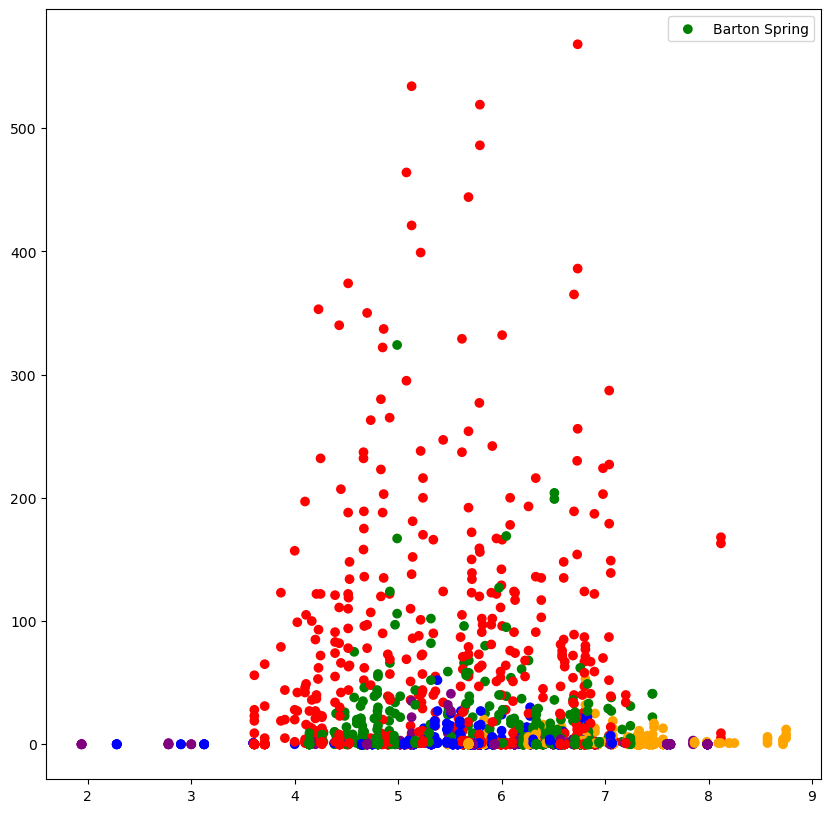

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [36]:
import random

df = summed_group.copy()
df = df[df["DISSOLVED_OXYGEN"] < 10]

colors = {"Eliza Spring": "red", "Old Mill (Sunken Gardens) Spring": "blue", "Barton Spring": "green", "Old Mill Stream (outflow from Sunken Gardens Pool)": "purple", "Upper Barton Spring": "orange"}
sites = df["SITE_NAME"].unique()

plt.figure(figsize=(10, 10))
# for idx, row in df.iterrows():
#     plt.scatter(row["DISSOLVED_OXYGEN"], row["RESULT"], c=colors[row["SITE_NAME"]])
plt.scatter(df["DISSOLVED_OXYGEN"], df["RESULT"], c=df["SITE_NAME"].map(lambda x: colors[x]))
plt.legend(sites)
# plt.scatter(df["DISSOLVED_OXYGEN"], df["RESULT"], c=colors[df["SITE_NAME"]])
plt.show()
plt.figure(figsize=(10, 10))



{'Eliza Spring': 'red', 'Old Mill (Sunken Gardens) Spring': 'blue', 'Barton Spring': 'green', 'Old Mill Stream (outflow from Sunken Gardens Pool)': 'purple', 'Upper Barton Spring': 'orange'}
5507    2002
9017    2002
9022    2002
8102    2002
8106    2002
        ... 
6357    2015
6338    2015
6361    2015
6341    2015
6362    2015
Name: YEAR, Length: 3093, dtype: int64
2002-08-01


,SAMPLE_DATA_NAME,SAMPLE_DATE,SITE_NAME,PARAMETER,SALAMANDERS,SIZE,SURFACE,RESULT,DISSOLVED_OXYGEN,YEAR
5507,08/2002 Barton Spring,2002-08-01,Barton Spring,BARTON SPRINGS SLMNDR (<1IN.) IN COBBLE/BOULDER,1.0,1.0,COBBLE/BOULDER,24.0,6.660,2002
6668,09/2002 Old Mill (Sunken Gardens) Spring,2002-09-01,Old Mill (Sunken Gardens) Spring,BARTON SPRINGS SLMNDR (<1IN.) IN COBBLE/BOULDER,1.0,1.0,COBBLE/BOULDER,2.0,5.775,2002
5509,08/2002 Eliza Spring,2002-08-01,Eliza Spring,AUSTIN BLIND SLMNDR (<1IN.) IN VEGETATION/MOSS,0.0,1.0,VEGETATION/MOSS,1.0,6.290,2002
5519,08/2002 Old Mill (Sunken Gardens) Spring,2002-08-01,Old Mill (Sunken Gardens) Spring,BARTON SPRINGS SLMNDR (<1IN.) IN VEGETATION/MOSS,1.0,1.0,VEGETATION/MOSS,4.0,6.770,2002
5511,08/2002 Eliza Spring,2002-08-01,Eliza Spring,BARTON SPRINGS SLMNDR (>=2IN.) IN VEGETATION/MOSS,1.0,2.0,VEGETATION/MOSS,1.0,6.290,2002
...,...,...,...,...,...,...,...,...,...,...
2265,03/2015 Old Mill (Sunken Gardens) Spring,2015-03-01,Old Mill (Sunken Gardens) Spring,AUSTIN BLIND SLMNDR (<1IN.) IN VEGETATION/MOSS,0.0,1.0,VEGETATION/MOSS,2.0,6.320,2015
6358,08/2015 Upper Barton Spring,2015-08-01,Upper Barton Spring,BARTON SPRINGS SLMNDR (<1IN.) IN VEGETATION/MOSS,1.0,1.0,VEGETATION/MOSS,0.0,7.430,2015
6341,08/2015 Upper Barton Spring,2015-08-01,Upper Barton Spring,AUSTIN BLIND SLMNDR (>=2IN.) IN VEGETATION/MOSS,0.0,2.0,VEGETATION/MOSS,0.0,7.430,2015
6354,08/2015 Upper Barton Spring,2015-08-01,Upper Barton Spring,BARTON SPRINGS SLMNDR (1-2IN.) IN VEGETATION/MOSS,1.0,1.5,VEGETATION/MOSS,0.0,7.430,2015


YEAR  SITE_NAME                                         
2002  Barton Spring                                         13.250000
      Eliza Spring                                           1.200000
      Old Mill (Sunken Gardens) Spring                       6.000000
2003  Barton Spring                                         10.833333
      Eliza Spring                                          20.600000
                                                              ...    
2014  Old Mill Stream (outflow from Sunken Gardens Pool)     0.500000
      Upper Barton Spring                                    1.000000
2015  Barton Spring                                          1.000000
      Old Mill (Sunken Gardens) Spring                       1.333333
      Upper Barton Spring                                    0.000000
Name: RESULT, Length: 63, dtype: float64

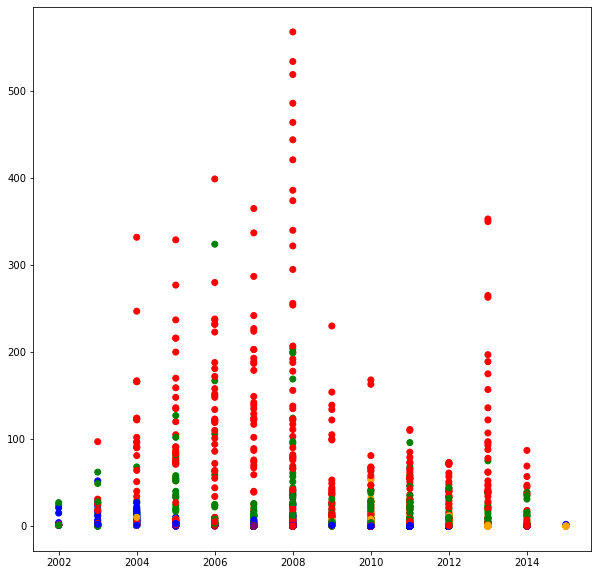

YEAR  SITE_NAME                                         
2002  Barton Spring                                         AxesSubplot(0.125,0.125;0.775x0.755)
      Eliza Spring                                          AxesSubplot(0.125,0.125;0.775x0.755)
      Old Mill (Sunken Gardens) Spring                      AxesSubplot(0.125,0.125;0.775x0.755)
2003  Barton Spring                                         AxesSubplot(0.125,0.125;0.775x0.755)
      Eliza Spring                                          AxesSubplot(0.125,0.125;0.775x0.755)
                                                                            ...                 
2014  Old Mill Stream (outflow from Sunken Gardens Pool)    AxesSubplot(0.125,0.125;0.775x0.755)
      Upper Barton Spring                                   AxesSubplot(0.125,0.125;0.775x0.755)
2015  Barton Spring                                         AxesSubplot(0.125,0.125;0.775x0.755)
      Old Mill (Sunken Gardens) Spring                      AxesSubplo

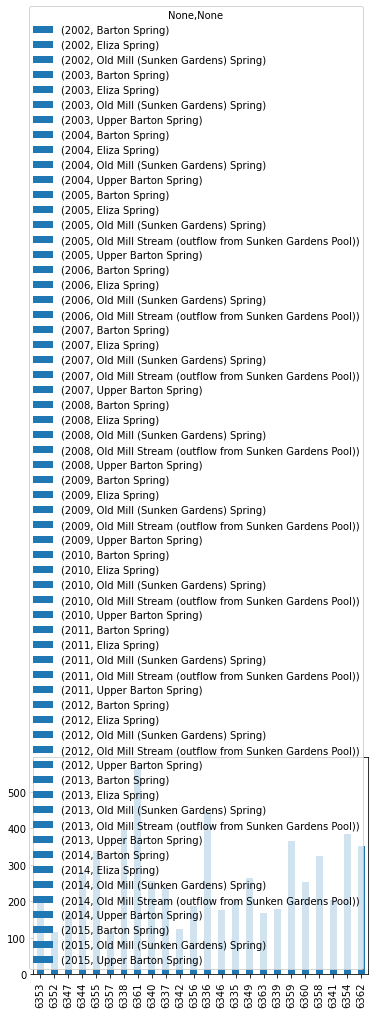

In [46]:
print(colors)

date_format = pd.DatetimeIndex(df["SAMPLE_DATE"])
df["YEAR"] = date_format.year
print(df["YEAR"])
df = df.sort_values(by = "YEAR")

min_date = df["SAMPLE_DATE"].min()
print(min_date)

#print(type(date_format))
#print(type(data["SAMPLE_DATE"]))
display(df)

grouped_sites = df.groupby(["YEAR", "SITE_NAME"])
#df.set_index("")
display(grouped_sites["RESULT"].mean())




plt.figure(figsize=(10, 10))
plt.scatter(df["YEAR"], df["RESULT"], c=df["SITE_NAME"].map(lambda x: colors[x]))
plt.show()


#grouped_sites.plot(x="SITE_NAME", y=["RESULT"], kind = "bar")
grouped_sites['RESULT'].plot(legend =True, kind='bar')



## Models

<AxesSubplot:>

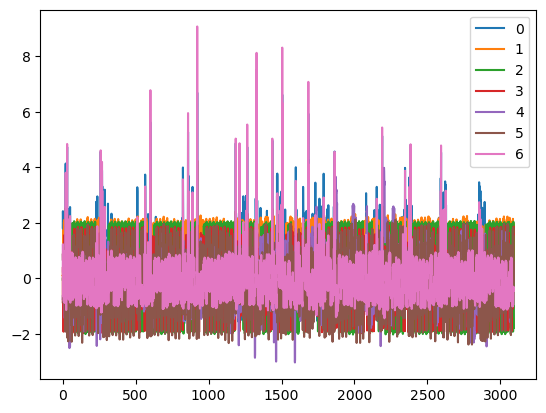

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#k-means for oxygen and salamder counts

#one-hot encoding for surface
pca_df = pd.get_dummies(df, columns= ["SURFACE"])

pca_df.drop(["SAMPLE_DATA_NAME", "PARAMETER", "SITE_NAME", "SAMPLE_DATE"], axis= 1, inplace=True)
# Remove categorical columns and pca reduction
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_df)
pca = PCA(n_components=.95,svd_solver ="full")
pca_data = pca.fit_transform(scaled_data)
df_data = pd.DataFrame(pca_data)
#df_data.head()



#PCA Reduced




In [45]:
from sklearn.manifold import MDS

def scatter(data, labels, numPoints = 500):

    numEntries = data.shape[0]
    start = random.randint(0, numEntries - numPoints)
    end = start + numPoints
    data = data.iloc[start:end, :]
    labels = labels.iloc[start:end]
    
    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(data)
    plt.scatter(mds_data[:, 0], mds_data[:, 1], c=labels, s=50)
    plt.show()

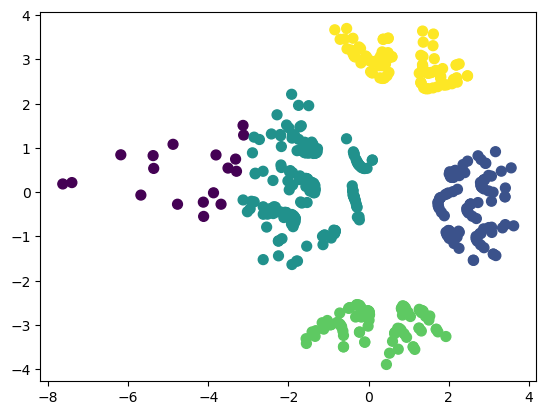

In [47]:
#K-MEANS Clustering

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#Estimated Eps = 6

best_clustering = (None, None)
for i in range(2, 7):
    kmeans = KMeans(n_clusters=i)
    k_labels = kmeans.fit_predict(df_data) #npArray
    s_score = silhouette_score(df_data, k_labels)
    if best_clustering[1] == None:
        best_clustering = (pd.Series(k_labels), s_score)
    elif s_score >= best_clustering[1]:
        best_clustering = (pd.Series(k_labels), s_score) 
          
scatter(df_data, best_clustering[0])

In [52]:
# your code goes here
df_data = pd.get_dummies(df, columns= ["SURFACE", "SITE_NAME"])
df_data.drop(["SAMPLE_DATA_NAME", "PARAMETER", "SAMPLE_DATE"], axis=1, inplace=True)
data_Y = df_data["RESULT"].ravel()
data_X = df_data.drop(['RESULT'], axis =1)
print(data_Y.shape)
print(data_X.shape)
data_X.head()


(3093,)
(3093, 12)


,SALAMANDERS,SIZE,DISSOLVED_OXYGEN,SURFACE_COBBLE/BOULDER,SURFACE_EXPOSED SUBSTRATE,SURFACE_LEAF LITTER,SURFACE_VEGETATION/MOSS,SITE_NAME_Barton Spring,SITE_NAME_Eliza Spring,SITE_NAME_Old Mill (Sunken Gardens) Spring,SITE_NAME_Old Mill Stream (outflow from Sunken Gardens Pool),SITE_NAME_Upper Barton Spring
123,1.0,1.0,6.26,1,0,0,0,1,0,0,0,0
134,1.0,1.5,6.12,1,0,0,0,0,1,0,0,0
135,1.0,1.0,6.12,1,0,0,0,0,1,0,0,0
136,1.0,2.0,6.12,1,0,0,0,0,1,0,0,0
142,0.0,1.5,6.25,0,0,0,1,0,0,1,0,0


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size =.2)
print("X_train=",X_train.shape, " y_train=", Y_train.shape)
print("X_test=",X_test.shape, " y_test=", Y_test.shape)

clf = DecisionTreeClassifier(criterion="entropy")
#these are features and labels
clf.fit(X_train, Y_train)
#from sklearn import tree
#tree.plot_tree(clf)

#testing the test data
pred_Y = clf.predict(X_test)

acc = sk.metrics.accuracy_score(Y_test, pred_Y)
print(f"the accuracy is:{acc}")


X_train= (2474, 12)  y_train= (2474,)
X_test= (619, 12)  y_test= (619,)
the accuracy is:0.5783521809369951
